In [1]:
import openai
from dotenv import load_dotenv
import os
import re

load_dotenv()

True

In [103]:
openai_api_key = os.getenv("OPENAI_API_KEY")

In [14]:
from langchain.document_loaders import PyPDFLoader

In [53]:
# Load the book
loader = PyPDFLoader("pdf/crime-and-punishment.pdf")
pages = loader.load()

In [54]:
print (f"This book has total of {len(pages)} pages.")

This book has total of 767 pages.


In [55]:
# First page has unnecessary content
pages = pages[1:]

In [56]:
# Define a list of texts to remove
texts_to_remove = ['Crime and Punishment', 'Free eBooks at Planet eBook.com', '']

# Define a pattern for page numbers and unwanted text
pattern_page_numbers = "^\d+"
pattern_unwanted_text = '|'.join(texts_to_remove)


regex_page_numbers = re.compile(pattern_page_numbers)
regex_unwanted_text = re.compile(pattern_unwanted_text, re.IGNORECASE)

In [57]:
for page in pages:
    page.page_content = regex_unwanted_text.sub('', page.page_content)
    page.page_content = page.page_content.strip()
    page.page_content = regex_page_numbers.sub('', page.page_content)

In [67]:
print(pages[5].page_content)

Chapter I
On an exceptionally hot evening early in July a young 
man came out of the garret in which he lodged in S. 
Place and walked slowly, as though in hesitation, towards 
K. bridge.
He had successfully avoided meeting his landlady on the 
staircase. His garret was under the roof of a high, five-sto -
ried house and was more like a cupboard than a room. The 
landlady who provided him with garret, dinners, and at -
tendance, lived on the floor below, and every time he went 
out he was obliged to pass her kitchen, the door of which 
invariably stood open. And each time he passed, the young 
man had a sick, frightened feeling, which made him scowl 
and feel ashamed. He was hopelessly in debt to his landlady, 
and was afraid of meeting her.
This was not because he was cowardly and abject, quite 
the contrary; but for some time past he had been in an over -
strained irritable condition, verging on hypochondria. He 
had become so completely absorbed in himself, and iso -
lated from his 

In [68]:
import copy
pages_copy = copy.deepcopy(pages)

In [69]:
preprocessed_pages = []

for i, page in enumerate(pages_copy):
    # Strip the page content of any leading or trailing whitespace
    page.page_content = page.page_content.strip()
    # If the page has less than 100 characters, check if it is a part title
    if len(page.page_content) < 100:
        # If the page starts with "PART" or "Part", append it to the next page
        if page.page_content.startswith("Part") or page.page_content.startswith("PART"):
            # If the current page is not the last page, get the next page and add the current page to it
            if i < len(pages_copy) - 1:
                next_page = pages_copy.pop(i + 1)
                next_page.page_content = page.page_content + next_page.page_content
                # Append the updated next page to the preprocessed list
                preprocessed_pages.append(next_page)
        # Otherwise, append it to the previous page
        else:
            # If the preprocessed list is not empty, get the last page and add the current page to it
            if preprocessed_pages:
                last_page = preprocessed_pages.pop()
                last_page.page_content += page.page_content
                # Append the updated last page to the preprocessed list
                preprocessed_pages.append(last_page)
    # Otherwise, append the page as it is to the preprocessed list
    else:
        preprocessed_pages.append(page)

In [159]:
print(preprocessed_pages[0].page_content)

Translator’s Preface
A few words about Dostoevsky himself may help the Eng -
lish reader to understand his work.
Dostoevsky was the son of a doctor. His parents were 
very hard- working and deeply religious people, but so poor 
that they lived with their five children in only two rooms. 
The father and mother spent their evenings in reading aloud 
to their children, generally from books of a serious charac -
ter.
Though always sickly and delicate Dostoevsky came out 
third in the final examination of the Petersburg school of 
Engineering. There he had already begun his first work, 
‘Poor Folk.’
This story was published by the poet Nekrassov in his 
review and was received with acclamations. The shy, un -
known youth found himself instantly something of a 
celebrity. A brilliant and successful career seemed to open 
before him, but those hopes were soon dashed. In 1849 he 
was arrested.
Though neither by temperament nor conviction a revolu -
tionist, Dostoevsky was one of a little group

In [85]:
print (f"After some cleaning this book has total of {len(preprocessed_pages)} pages.")

After some cleaning this book has total of 756 pages.


In [88]:
# Combine the pages, and replace the tabs with spaces
text = ""

for page in preprocessed_pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [90]:
from langchain import OpenAI

In [91]:
llm = OpenAI(temperature=0, openai_api_key=openai_api_key)

In [104]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 334889 tokens in it


In [95]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [100]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=12000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])

In [101]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 128 documents


In [115]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

vectors_first25 = embeddings.embed_documents([x.page_content for x in docs[:25]])

In [118]:
vectors_25to50 = embeddings.embed_documents([x.page_content for x in docs[25:50]])

In [119]:
vectors_50to75 = embeddings.embed_documents([x.page_content for x in docs[50:75]])

In [123]:
vectors_75to100 = embeddings.embed_documents([x.page_content for x in docs[75:100]])

In [124]:
vectors_100to128 = embeddings.embed_documents([x.page_content for x in docs[100:]])

In [160]:
vectors = vectors_first25 + vectors_25to50 + vectors_50to75 + vectors_75to100 + vectors_100to128

In [146]:
import pandas as pd

In [168]:
doc_vectors = {}
for i in range(len(vectors)):
    doc_name = "doc" + str(i+1)
    doc_vectors[doc_name] = [vectors[i]]


df = pd.DataFrame.from_dict(doc_vectors, orient="index", columns=["embeddings"])
df

,embeddings
doc1,"[0.011597242568533046, 0.0003537849233094882, ..."
doc2,"[-0.012588275368704223, -0.007729642884629924,..."
doc3,"[0.006247837778099532, -0.011888150581990902, ..."
doc4,"[0.007191718364664765, -0.00739877371923526, 0..."
doc5,"[-0.012162613987909642, 0.010884197702176215, ..."
...,...
doc124,"[-0.004078946483233099, -0.006772457524426935,..."
doc125,"[0.011603843581650886, 0.0034337903383435298, ..."
doc126,"[0.01221271396551256, 0.005210238417225174, 0...."
doc127,"[0.02076291390318825, -0.009703654319827247, 0..."


In [170]:
# save the data frame as a csv file
df.to_csv('embeddings.csv')

In [230]:
embeddings = pd.read_csv("embeddings.csv", index_col=0)

In [231]:
embeddings

,embeddings
doc1,"[0.011597242568533046, 0.0003537849233094882, ..."
doc2,"[-0.012588275368704223, -0.007729642884629924,..."
doc3,"[0.006247837778099532, -0.011888150581990902, ..."
doc4,"[0.007191718364664765, -0.00739877371923526, 0..."
doc5,"[-0.012162613987909642, 0.010884197702176215, ..."
...,...
doc124,"[-0.004078946483233099, -0.006772457524426935,..."
doc125,"[0.011603843581650886, 0.0034337903383435298, ..."
doc126,"[0.01221271396551256, 0.005210238417225174, 0...."
doc127,"[0.02076291390318825, -0.009703654319827247, 0..."


In [232]:
embeddings['embeddings'] = embeddings['embeddings'].apply(ast.literal_eval)

In [235]:
embeddings_list = embeddings['embeddings'].tolist()

In [239]:
results = []
for vector, embedding in zip(vectors, embeddings_list):
  # compare the vector and the embedding using the np.array_equal function
  result = np.array_equal(vector, embedding)
  results.append(result)

In [240]:
results

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [242]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Optimal number of clusters: 2


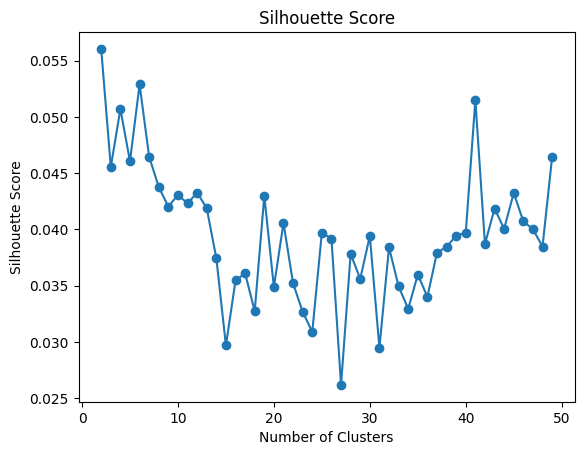

In [276]:
silhouette_scores = []
cluster_range = range(2, 50)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(vectors)
    labels = kmeans.labels_
    score = silhouette_score(vectors, labels)
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [277]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddingMatrix)

KMeans(n_clusters=2, random_state=42)

In [278]:
kmeans.labels_

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0])

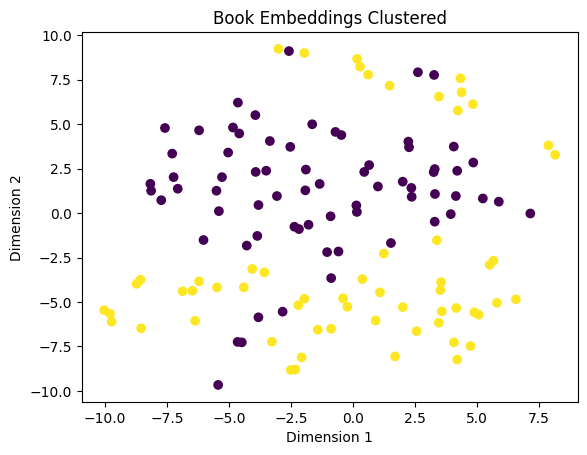

In [279]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(embeddingMatrix)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [280]:
closest_indices = []

# Loop through the number of clusters you have
for i in range(n_clusters):
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [281]:
selected_indices = sorted(closest_indices)
selected_indices

[70, 102]

In [282]:
selected_docs = [docs[doc] for doc in selected_indices]
len(selected_docs)

2

In [283]:
print(selected_docs[0].page_content)

Mr. Svidrigaïlov. It makes me miserable.’
‘He has just been to see me,’ said Raskolnikov, breaking 
his silence for the first time.There were exclamations from all, and they all turned to 
him. Even Pyotr Petrovitch was roused.
‘An hour and a half ago, he came in when I was asleep, 
waked me, and introduced himself,’ Raskolnikov continued. 
‘He was fairly cheerful and at ease, and quite hopes that we 
shall become friends. He is particularly anxious, by the way, 
Dounia, for an interview with you, at which he asked me to 
assist. He has a proposition to make to you, and he told me 
about it. He told me, too, that a week before her death Marfa 
Petrovna left you three thousand roubles in her will, Dou -
nia, and that you can receive the money very shortly.’
‘Thank God!’ cried Pulcheria Alexandrovna, crossing 
herself. ‘Pray for her soul, Dounia!’
‘It’s a fact!’ broke from Luzhin.
‘Tell us, what more?’ Dounia urged Raskolnikov.
‘Then he said that he wasn’t rich and all the estate was 
le

In [ ]:
llm3 = ChatOpenAI(temperature=0,
                 openai_api_key=openai_api_key,
                 max_tokens=1000,
                 model='gpt-3.5-turbo'
                )